## **PENGELOMPOKAN KEY PERFORMANCE INDICATOR DOSEN DAN TENDIK INSTITUT TEKNOLOGI PLN MENGGUNAKAN ALGORITMA K-MEANS**

**Pengelompokkan** kinerja dosen dan tenaga kependidikan ITPLN berdasarkan data *Key Performance Indicator (KPI)* menggunakan **algoritma K-Means**. Dengan pendekatan *Elbow Method*, jumlah klaster optimal ditentukan untuk mengidentifikasi kelompok kinerja yang berbeda. Kualitas klaster kemudian **divalidasi** menggunakan metode Davies-Bouldin Index (DBI)  memastikan bahwa setiap individu sesuai dengan **karakteristik kinerjanya**.

### 1. Import Library dan Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import winsorize
from sklearn.metrics import davies_bouldin_score
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import joblib

In [2]:
file_path = r'C:\Users\muham\Documents\Bismillahirrahmanirrahim_SKRIPSI\DATA KPI 2023.xlsx'

data = pd.read_excel(file_path)

#### **2. Analisis Data Awal**

In [3]:
# Menampilkan data awal dan informasi terkait untuk analisis
print("Data awal:")
print(data.head())  # Menampilkan 5 baris pertama data
print("Jumlah nilai NaN di data awal:")
print(data.isnull().sum())  # Mengecek jumlah nilai kosong di setiap kolom

Data awal:
  Nama Pegawai Bagian/Fakultas   P  Nilai P   K  Nilai K Total Nilai Talenta
0            A             BAA  P3     88.0  K2      2.0  P3K2        Sedang
1            B             BAA  P2     94.0  K1      1.0  P2K1   Baik Sekali
2            C             BAA  P2     94.0  K2      2.0  P2K2          Baik
3            D             BAA  P2     94.0  K2      2.0  P2K2          Baik
4            E             BAA  P2     94.0  K2      2.0  P2K2          Baik
Jumlah nilai NaN di data awal:
Nama Pegawai        0
Bagian/Fakultas     0
P                  30
Nilai P            30
K                  30
Nilai K            30
Total              30
Nilai Talenta       0
dtype: int64


In [4]:
# Menampilkan informasi tipe data untuk memastikan data siap diproses
print("\nInfo Data:")
print(data.info())  


Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Nama Pegawai     275 non-null    object 
 1   Bagian/Fakultas  275 non-null    object 
 2   P                245 non-null    object 
 3   Nilai P          245 non-null    float64
 4   K                245 non-null    object 
 5   Nilai K          245 non-null    float64
 6   Total            245 non-null    object 
 7   Nilai Talenta    275 non-null    object 
dtypes: float64(2), object(6)
memory usage: 17.3+ KB
None


### **3.Preprocessing dengan Custom Transformers**

In [5]:
# 1. MissingValueHandler - Menghapus baris dengan nilai kosong
class MissingValueHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        initial_shape = X.shape
        X_cleaned = X.dropna().reset_index(drop=True)
        removed_rows = initial_shape[0] - X_cleaned.shape[0]
        print(f"MissingValueHandler: Menghapus {removed_rows} baris karena nilai kosong.")
        return X_cleaned

# 2. DuplicateHandler - Menghapus baris duplikat
class DuplicateHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        initial_shape = X.shape
        X_cleaned = X.drop_duplicates().reset_index(drop=True)
        removed_rows = initial_shape[0] - X_cleaned.shape[0]
        print(f"DuplicateHandler: Menghapus {removed_rows} baris duplikat.")
        return X_cleaned

# 3. NumerisasiHandler - Mengonversi kategori ke nilai numerik
class NumerisasiHandler(BaseEstimator, TransformerMixin):
    def __init__(self, numerisasi_map):
        self.numerisasi_map = numerisasi_map

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col, mapping in self.numerisasi_map.items():
            if col in X.columns:
                initial_shape = X.shape
                X[f"{col}_num"] = X[col].map(mapping)
                unconverted_count = X[f"{col}_num"].isna().sum()
                print(f"NumerisasiHandler: Mengonversi {initial_shape[0] - unconverted_count} nilai ke numerik untuk kolom '{col}'.")
                if unconverted_count > 0:
                    print(f"NumerisasiHandler: {unconverted_count} nilai tidak terkonversi untuk kolom '{col}'.")
        return X

# 4. OutlierHandlerWinsorize - Menangani outlier dengan Winsorization
class OutlierHandlerWinsorize(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.01, 0.01)):
        self.limits = limits

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        numeric_columns = X.select_dtypes(include=[float, int]).columns
        for col in numeric_columns:
            initial_values = X[col].copy()
            # Hitung outlier sebelum Winsorization
            outlier_count = ((initial_values < initial_values.quantile(self.limits[0])) | 
                             (initial_values > initial_values.quantile(1 - self.limits[1]))).sum()
            print(f"OutlierHandlerWinsorize: Terdapat {outlier_count} outlier pada kolom '{col}' sebelum Winsorization.")
            X[col] = winsorize(X[col], limits=self.limits)
            changed_count = (initial_values != X[col]).sum()
            if changed_count > 0:
                print(f"OutlierHandlerWinsorize: Mengganti {changed_count} outlier pada kolom '{col}'.")
            else:
                print(f"OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom '{col}'.")
        return X


### 4. Pipeline Preprocessing

In [6]:
# Numerisasi Map
numerisasi_map = {
    'P': {'P1': 1, 'P2': 2, 'P3': 3, 'P4': 4, 'P5': 5},
    'K': {'K1': 1, 'K2': 2, 'K3': 3, 'K4': 4}
}

# Pipeline Preprocessing
pipeline_preprocessing = Pipeline([
    ('missing_value_handler', MissingValueHandler()),  # Hapus baris dengan nilai kosong
    ('duplicate_handler', DuplicateHandler()),         # Hapus duplikat
    ('numerisasi_handler', NumerisasiHandler(numerisasi_map=numerisasi_map)),  # Numerisasi
    ('outlier_handler', OutlierHandlerWinsorize()),    # Tangani outlier
])

In [7]:
# Menjalankan pipeline hanya sekali
if 'fixed_data_cleaned' not in globals():
    fixed_data_cleaned = pipeline_preprocessing.fit_transform(data)

# Menggunakan dataset tetap
data_cleaned = copy.deepcopy(fixed_data_cleaned)

MissingValueHandler: Menghapus 30 baris karena nilai kosong.
DuplicateHandler: Menghapus 0 baris duplikat.
NumerisasiHandler: Mengonversi 245 nilai ke numerik untuk kolom 'P'.
NumerisasiHandler: Mengonversi 245 nilai ke numerik untuk kolom 'K'.
OutlierHandlerWinsorize: Terdapat 0 outlier pada kolom 'Nilai P' sebelum Winsorization.
OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom 'Nilai P'.
OutlierHandlerWinsorize: Terdapat 0 outlier pada kolom 'Nilai K' sebelum Winsorization.
OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom 'Nilai K'.
OutlierHandlerWinsorize: Terdapat 0 outlier pada kolom 'P_num' sebelum Winsorization.
OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom 'P_num'.
OutlierHandlerWinsorize: Terdapat 0 outlier pada kolom 'K_num' sebelum Winsorization.
OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom 'K_num'.


In [8]:
# Menampilkan data yang dihapus oleh MissingValueHandler
def get_missing_data(original_data, cleaned_data):
    missing_data = original_data[original_data.isnull().any(axis=1)]
    return missing_data

# Simpan dataset asli sebelum preprocessing
original_data = copy.deepcopy(data)

# Jalankan preprocessing
fixed_data_cleaned = pipeline_preprocessing.fit_transform(original_data)

data_cleaned = copy.deepcopy(fixed_data_cleaned)

# Tampilkan data yang dihapus karena nilai kosong
missing_data = get_missing_data(original_data, data_cleaned)
print("Data yang Dihapus karena Nilai Kosong:")
print(missing_data)

MissingValueHandler: Menghapus 30 baris karena nilai kosong.
DuplicateHandler: Menghapus 0 baris duplikat.
NumerisasiHandler: Mengonversi 245 nilai ke numerik untuk kolom 'P'.
NumerisasiHandler: Mengonversi 245 nilai ke numerik untuk kolom 'K'.
OutlierHandlerWinsorize: Terdapat 0 outlier pada kolom 'Nilai P' sebelum Winsorization.
OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom 'Nilai P'.
OutlierHandlerWinsorize: Terdapat 0 outlier pada kolom 'Nilai K' sebelum Winsorization.
OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom 'Nilai K'.
OutlierHandlerWinsorize: Terdapat 0 outlier pada kolom 'P_num' sebelum Winsorization.
OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom 'P_num'.
OutlierHandlerWinsorize: Terdapat 0 outlier pada kolom 'K_num' sebelum Winsorization.
OutlierHandlerWinsorize: Tidak ada outlier yang ditemukan pada kolom 'K_num'.
Data yang Dihapus karena Nilai Kosong:
    Nama Pegawai Bagian/Fakultas    P  Nilai P    K 

#### Hasil Preprocessing

In [9]:
# Print hasil preprocessing
print("Data Sebelum Preprocessing:\n")
print(data.head(10).to_string(index=False))
print("\nRingkasan Data Sebelum Preprocessing:\n")
print(data.info())

print("\nData Setelah Preprocessing:\n")
print(data_cleaned.head(10).to_string(index=False))
print("\nRingkasan Data Setelah Preprocessing:\n")
print(data_cleaned.info())
print(data_cleaned[['P_num', 'K_num']].head())

Data Sebelum Preprocessing:

Nama Pegawai Bagian/Fakultas  P  Nilai P  K  Nilai K Total Nilai Talenta
           A             BAA P3     88.0 K2      2.0  P3K2        Sedang
           B             BAA P2     94.0 K1      1.0  P2K1   Baik Sekali
           C             BAA P2     94.0 K2      2.0  P2K2          Baik
           D             BAA P2     94.0 K2      2.0  P2K2          Baik
           E             BAA P2     94.0 K2      2.0  P2K2          Baik
           F             BAG P2     94.0 K2      2.0  P2K2          Baik
           G             BAG P2     94.0 K2      2.0  P2K2          Baik
           H             BAG P2     94.0 K2      2.0  P2K2          Baik
           I             BAG P2     94.0 K2      2.0  P2K2          Baik
           J            BAKT P2     94.0 K2      2.0  P2K2          Baik

Ringkasan Data Sebelum Preprocessing:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 8 columns):
 #   Column           No

### 5. Analisis Korelasi

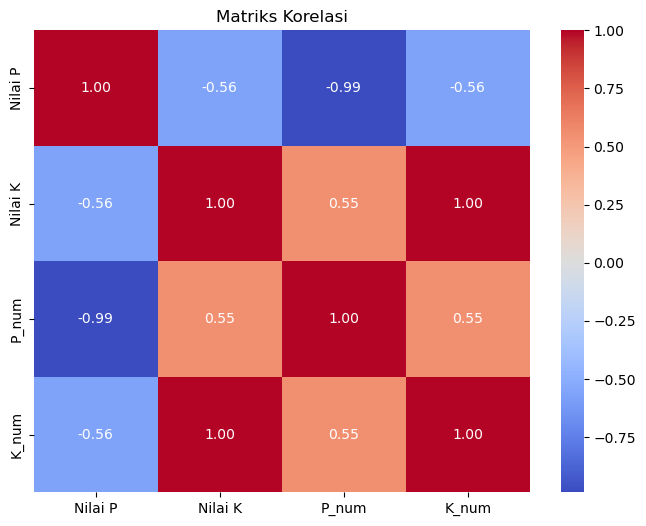

In [10]:
# Memilih hanya kolom numerik untuk korelasi
numeric_data = data_cleaned.select_dtypes(include=[np.number])

# Menghitung matriks korelasi
correlation_matrix = numeric_data.corr()

# Visualisasi matriks korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

## CLUSTERING DENGAN K-MEANS dengan ELBOW DAN DBI

###  Metode Elbow

C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

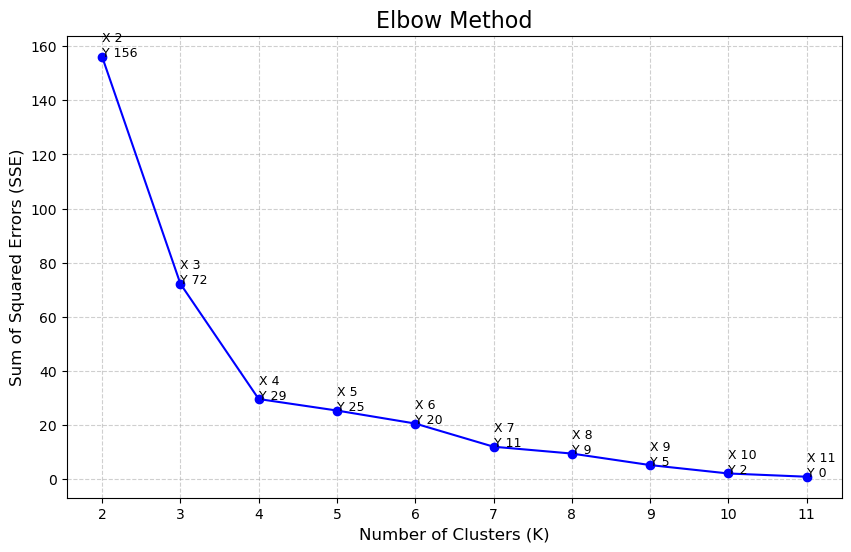

In [11]:
# Metode Elbow
# Menentukan jumlah cluster optimal menggunakan metode Elbow
SSE = []
K_range = range(2, 12)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_cleaned[['P_num', 'K_num']])
    SSE.append(kmeans.inertia_)  # Menyimpan nilai SSE (Sum of Squared Errors) dari hasil K-Means

# Visualisasi grafik Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, SSE, marker='o', linestyle='-', color='blue')
for i, txt in enumerate(SSE):
    plt.text(K_range[i], SSE[i], f'X {K_range[i]}\nY {int(SSE[i])}', fontsize=9, color='black')

plt.title("Elbow Method", fontsize=16)
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Sum of Squared Errors (SSE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(K_range)
plt.show()

In [12]:
optimal_k = 6
print(f"Jumlah klaster optimal: {optimal_k}")

Jumlah klaster optimal: 6


### K-Means

In [13]:
if 'fixed_labels' not in globals() or 'fixed_centroids' not in globals():
    print("Melakukan klasterisasi K-Means karena hasil belum disimpan sebelumnya...")
    
    # Jalankan K-Means
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(data_cleaned[['P_num', 'K_num']])
    
    # Simpan hasil klasterisasi
    fixed_labels = copy.deepcopy(kmeans.labels_)
    fixed_centroids = copy.deepcopy(kmeans.cluster_centers_)
    
    # Tambahkan kolom Cluster ke dalam data_cleaned
    data_cleaned['Cluster'] = fixed_labels

    # Simpan data yang sudah memiliki Cluster sebagai fixed_data_cleaned
    fixed_data_cleaned = copy.deepcopy(data_cleaned)

elif 'Cluster' not in data_cleaned.columns:
    print("Menambahkan kolom 'Cluster' ke data_cleaned karena sebelumnya tidak ada...")
    data_cleaned['Cluster'] = fixed_labels  # Tambahkan cluster jika hilang

# Gunakan hasil tetap
labels = fixed_labels
centroids = fixed_centroids
data_cleaned = fixed_data_cleaned  # Pastikan data_cleaned menggunakan data tetap

# Pastikan kolom 'Cluster' ada di data_cleaned
if 'Cluster' not in data_cleaned.columns:
    raise ValueError("Kolom 'Cluster' masih belum ada setelah proses klasterisasi. Periksa kembali alur kode.")

# Simpan centroid ke dalam DataFrame
data_centroids = pd.DataFrame(centroids, columns=['P_num', 'K_num'])
    
##simpan model
joblib.dump(kmeans, 'kmeans_model.pkl')

# Menampilkan centroid
print("Koordinat Centroid:")
for i, centroid in enumerate(centroids):
    print(f"Centroid Cluster {i}: P_num={centroid[0]:.4f}, K_num={centroid[1]:.4f}")

# Hitung Davies-Bouldin Index hanya jika belum pernah dilakukan sebelumnya
if 'fixed_dbi_score' not in globals():
    print("Menghitung Davies-Bouldin Index (DBI) karena belum tersimpan...")
    features = data_cleaned[['P_num', 'K_num']].values
    clusters = data_cleaned['Cluster'].values
    fixed_dbi_score = davies_bouldin_score(features, clusters)

print(f"Nilai Davies-Bouldin Index (DBI): {fixed_dbi_score:.4f}")

Melakukan klasterisasi K-Means karena hasil belum disimpan sebelumnya...
Koordinat Centroid:
Centroid Cluster 0: P_num=3.0556, K_num=2.0741
Centroid Cluster 1: P_num=1.8571, K_num=1.0000
Centroid Cluster 2: P_num=1.9580, K_num=2.0000
Centroid Cluster 3: P_num=4.8571, K_num=2.7143
Centroid Cluster 4: P_num=5.0000, K_num=4.0000
Centroid Cluster 5: P_num=2.0000, K_num=3.0000
Menghitung Davies-Bouldin Index (DBI) karena belum tersimpan...
Nilai Davies-Bouldin Index (DBI): 0.3349


C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


###  Davies-Bouldin Index (DBI)

In [14]:
from sklearn.metrics import davies_bouldin_score

# Pilih fitur untuk perhitungan DBI
features = data_cleaned[['P_num', 'K_num']].values
clusters = data_cleaned['Cluster'].values

# Hitung Davies-Bouldin Index
dbi_score = davies_bouldin_score(features, clusters)

print(f"Nilai Davies-Bouldin Index (DBI): {dbi_score:.4f}")

Nilai Davies-Bouldin Index (DBI): 0.3349


#### Visualisasi DBI untuk beberapa nilai K

C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

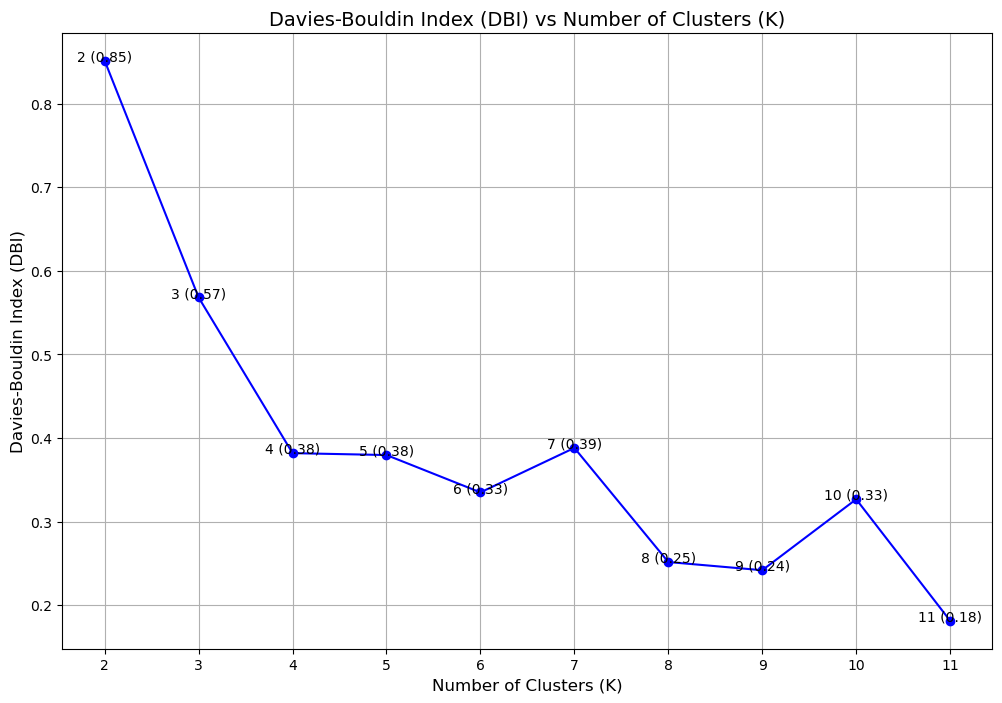

In [15]:
# Visualisasi DBI untuk beberapa nilai K
dbi_results = []
for k in range(2, 12):  # Range diperbaiki sesuai evaluasi klaster 2-12
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_cleaned[['P_num', 'K_num']])
    dbi = davies_bouldin_score(data_cleaned[['P_num', 'K_num']], labels)
    dbi_results.append({'K': k, 'DBI': dbi})

# Buat DataFrame untuk hasil DBI
dbi_df = pd.DataFrame(dbi_results)

# Plot DBI vs K
plt.figure(figsize=(12, 8))
plt.plot(dbi_df['K'], dbi_df['DBI'], marker='o', linestyle='-', color='b')

# Menambahkan label pada tiap titik
for i in range(len(dbi_df)):
    plt.text(dbi_df['K'][i], dbi_df['DBI'][i],
             f"{dbi_df['K'][i]} ({dbi_df['DBI'][i]:.2f})",
             fontsize=10, ha='center')

plt.title("Davies-Bouldin Index (DBI) vs Number of Clusters (K)", fontsize=14)
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Davies-Bouldin Index (DBI)", fontsize=12)
plt.xticks(range(2, 12))
plt.grid(True)
plt.show()

# Kesimpulan Analisis SSE dan DBI

Berdasarkan analisis **Sum of Squared Errors (SSE)** dan **Davies-Bouldin Index (DBI)**, **K = 6** dipilih sebagai jumlah klaster optimal  

Dari hasil **SSE**, pada **K = 6**, nilai SSE adalah **20**, menunjukkan variabilitas intra-klaster yang cukup rendah. Penurunan SSE dari **K = 5** ke **K = 6** sebesar **5 unit** masih signifikan, namun setelah itu (K = 6 ke K = 7 atau K = 8), penurunan SSE menjadi sangat kecil (**9 unit untuk K = 7** dan hanya **2 unit untuk K = 8**), menandakan bahwa menambah jumlah klaster setelah K = 6 memberikan manfaat tambahan yang minim dalam mengurangi variabilitas. 

Sementara itu, dari hasil **DBI**, pada **K = 6**, nilai DBI sebesar **0.33** yang lebih rendah dibandingkan **K = 4 (0.38)**, **K = 5 (0.38)**, dan **K = 7 (0.39)**, menunjukkan klaster pada K = 6 lebih kompak (intra-klaster kecil) dan lebih terpisah dengan baik (inter-klaster besar). Meskipun DBI untuk **K = 8** adalah yang terendah (**0.25**), peningkatan jumlah klaster hingga 8 hanya memberikan sedikit peningkatan kualitas klasterisasi sementara menambah kompleksitas interpretasi data. 

Oleh karena itu, **K = 6** dipilih sebagai jumlah klaster optimal karena memberikan kualitas klasterisasi yang baik dengan penurunan SSE signifikan, sementara tetap menjaga interpretasi yang sederhana dan praktis.
ktis.
```

###  Analisis Klaster

In [16]:
data_cleaned

,Nama Pegawai,Bagian/Fakultas,P,Nilai P,K,Nilai K,Total,Nilai Talenta,P_num,K_num,Cluster
0,A,BAA,P3,88.0,K2,2.0,P3K2,Sedang,3,2,0
1,B,BAA,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
2,C,BAA,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
3,D,BAA,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
4,E,BAA,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
240,K10,TC,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
241,L10,WTE,P5,68.0,K4,4.0,P5K4,Kurang,5,4,4
242,M10,WTE,P5,68.0,K4,4.0,P5K4,Kurang,5,4,4
243,N10,WTE,P5,68.0,K4,4.0,P5K4,Kurang,5,4,4


In [17]:
# Menghitung interval setiap atribut di setiap cluster
cluster_ranges = data_cleaned.groupby('Cluster').agg({
    'P_num': ['min', 'max'],
    'K_num': ['min', 'max']
}).reset_index()

# Menyimpan hasil pertama kali ke dalam variabel tetap
if 'fixed_cluster_ranges' not in globals():
    fixed_cluster_ranges = copy.deepcopy(cluster_ranges)

print("\nInterval setiap atribut di setiap cluster:")
print(fixed_cluster_ranges)


Interval setiap atribut di setiap cluster:
  Cluster P_num     K_num    
            min max   min max
0       0     3   4     2   3
1       1     1   2     1   1
2       2     1   2     2   2
3       3     4   5     2   3
4       4     5   5     4   4
5       5     2   2     3   3


In [18]:
# Membuat ringkasan berdasarkan cluster
cluster_ranges = data_cleaned.groupby('Cluster').agg({
    'P_num': ['min', 'max'],  # Rentang P_num
    'K_num': ['min', 'max'],  # Rentang K_num
    'Nilai Talenta': lambda x: list(x.unique())  # Daftar unik Nilai Talenta
}).reset_index()

# Tampilkan hasil
print("Ringkasan Analisis Klaster dengan Nilai talenta:")
print(cluster_ranges)

Ringkasan Analisis Klaster dengan Nilai talenta:
  Cluster P_num     K_num                        Nilai Talenta
            min max   min max                         <lambda>
0       0     3   4     2   3                 [Sedang, sedang]
1       1     1   2     1   1   [Baik Sekali, Sangat Istimewa]
2       2     1   2     2   2  [Baik, Baik  , Baik , Istimewa]
3       3     4   5     2   3                 [Kurang, Sedang]
4       4     5   5     4   4                         [Kurang]
5       5     2   2     3   3                           [Baik]


#### 1. Menampilkan Data Berdasarkan Cluster

In [19]:
# Menampilkan Data Berdasarkan Cluster
for cluster in data_cleaned['Cluster'].unique():
    print(f"\nCluster {cluster}:")
    display(data_cleaned[data_cleaned['Cluster'] == cluster])


Cluster 0:


,Nama Pegawai,Bagian/Fakultas,P,Nilai P,K,Nilai K,Total,Nilai Talenta,P_num,K_num,Cluster
0,A,BAA,P3,88.0,K2,2.0,P3K2,Sedang,3,2,0
14,O,BAUM,P3,88.0,K2,2.0,P3K2,Sedang,3,2,0
29,D1,BPA,P3,88.0,K3,3.0,P3K3,Sedang,3,3,0
40,O1,BSDM,P3,88.0,K3,3.0,P3K3,Sedang,3,3,0
41,P1,BSFU,P3,88.0,K2,2.0,P3K2,Sedang,3,2,0
42,Q1,BSFU,P3,88.0,K3,3.0,P3K3,Sedang,3,3,0
47,V1,BSFU,P3,88.0,K2,2.0,P3K2,Sedang,3,2,0
50,Y1,BSFU,P3,88.0,K3,3.0,P3K3,Sedang,3,3,0
52,A2,FKET,P3,88.0,K2,2.0,P3K2,Sedang,3,2,0
55,E2,FKET,P3,88.0,K2,2.0,P3K2,Sedang,3,2,0



Cluster 1:


,Nama Pegawai,Bagian/Fakultas,P,Nilai P,K,Nilai K,Total,Nilai Talenta,P_num,K_num,Cluster
1,B,BAA,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
10,K,BAKT,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
15,P,BAUM,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
16,Q,BAUM,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
17,R,BAUM,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
21,V,BHMS,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
22,W,BHMS,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
28,C1,BLKA,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
33,H1,BPUS,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1
37,L1,BSDM,P2,94.0,K1,1.0,P2K1,Baik Sekali,2,1,1



Cluster 2:


,Nama Pegawai,Bagian/Fakultas,P,Nilai P,K,Nilai K,Total,Nilai Talenta,P_num,K_num,Cluster
2,C,BAA,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
3,D,BAA,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
4,E,BAA,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
5,F,BAG,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
6,G,BAG,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
232,B10,PDSI,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
233,C10,PDSI,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
234,D10,PJM,P2,94.0,K2,2.0,P2K2,Baik,2,2,2
235,E10,PJM,P2,94.0,K2,2.0,P2K2,Baik,2,2,2



Cluster 5:


,Nama Pegawai,Bagian/Fakultas,P,Nilai P,K,Nilai K,Total,Nilai Talenta,P_num,K_num,Cluster
36,K1,BRP,P2,94.0,K3,3.0,P2K3,Baik,2,3,5
46,U1,BSFU,P2,94.0,K3,3.0,P2K3,Baik,2,3,5
56,F2,FKET,P2,94.0,K3,3.0,P2K3,Baik,2,3,5
96,G4,FKET,P2,94.0,K3,3.0,P2K3,Baik,2,3,5
180,Y7,FTEN,P2,94.0,K3,3.0,P2K3,Baik,2,3,5



Cluster 4:


,Nama Pegawai,Bagian/Fakultas,P,Nilai P,K,Nilai K,Total,Nilai Talenta,P_num,K_num,Cluster
48,W1,BSFU,P5,68.0,K4,4.0,P5K4,Kurang,5,4,4
241,L10,WTE,P5,68.0,K4,4.0,P5K4,Kurang,5,4,4
242,M10,WTE,P5,68.0,K4,4.0,P5K4,Kurang,5,4,4
243,N10,WTE,P5,68.0,K4,4.0,P5K4,Kurang,5,4,4



Cluster 3:


,Nama Pegawai,Bagian/Fakultas,P,Nilai P,K,Nilai K,Total,Nilai Talenta,P_num,K_num,Cluster
85,V3,FKET,P5,68.0,K3,3.0,P5K3,Kurang,5,3,3
86,W3,FKET,P5,68.0,K2,2.0,P5K2,Kurang,5,2,3
87,X3,FKET,P5,68.0,K3,3.0,P5K3,Kurang,5,3,3
123,N5,FTBE,P5,68.0,K3,3.0,P5K3,Kurang,5,3,3
141,J6,FTBE,P4,79.0,K3,3.0,P4K3,Sedang,4,3,3
216,L9,FTIK,P5,68.0,K2,2.0,P5K2,Kurang,5,2,3
219,O9,FTIK,P5,68.0,K3,3.0,P5K3,Kurang,5,3,3


In [20]:
import pandas as pd

# Pastikan kolom Cluster memiliki tipe data yang sesuai
data_cleaned['Cluster'] = data_cleaned['Cluster'].astype(str)

# Simpan hasil klasterisasi ke dalam file Excel dengan sheet terpisah
file_path = "hasil_klasterisasi.xlsx"

with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
    unique_clusters = data_cleaned['Cluster'].unique()  # Ambil daftar klaster unik
    print(f"Klaster yang ditemukan: {unique_clusters}")  # Debugging: pastikan klaster terdeteksi
    for cluster in unique_clusters:
        cluster_data = data_cleaned[data_cleaned['Cluster'] == cluster]
        if not cluster_data.empty:
            cluster_data.to_excel(writer, sheet_name=f'Cluster_{cluster}', index=False)
        else:
            print(f"Cluster {cluster} kosong, tidak disimpan.")

print(f"Hasil klasterisasi telah disimpan dalam file {file_path}")


Klaster yang ditemukan: ['0' '1' '2' '5' '4' '3']
Hasil klasterisasi telah disimpan dalam file hasil_klasterisasi.xlsx


#### 2. Menampilkan Distribusi Atribut per Klaster

In [21]:
for cluster in data_cleaned['Cluster'].unique():
    cluster_data = data_cleaned[data_cleaned['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.describe())


Cluster 0:
         Nilai P    Nilai K      P_num      K_num
count  54.000000  54.000000  54.000000  54.000000
mean   87.500000   2.074074   3.055556   2.074074
std     2.080911   0.264351   0.231212   0.264351
min    79.000000   2.000000   3.000000   2.000000
25%    88.000000   2.000000   3.000000   2.000000
50%    88.000000   2.000000   3.000000   2.000000
75%    88.000000   2.000000   3.000000   2.000000
max    88.000000   3.000000   4.000000   3.000000

Cluster 1:
          Nilai P  Nilai K      P_num  K_num
count   56.000000     56.0  56.000000   56.0
mean    95.000000      1.0   1.857143    1.0
std      2.471658      0.0   0.353094    0.0
min     94.000000      1.0   1.000000    1.0
25%     94.000000      1.0   2.000000    1.0
50%     94.000000      1.0   2.000000    1.0
75%     94.000000      1.0   2.000000    1.0
max    101.000000      1.0   2.000000    1.0

Cluster 2:
          Nilai P  Nilai K       P_num  K_num
count  119.000000    119.0  119.000000  119.0
mean    94.294118

#### 3. Menamilkan distribusi jumlah data di setiap cluster

In [22]:
# Melihat distribusi jumlah data di setiap cluster
cluster_distribution = data_cleaned['Cluster'].value_counts().reset_index()
cluster_distribution.columns = ['Cluster', 'Count']
# Tampilkan distribusi cluster dalam tabel
print("\nDistribusi Cluster:")
print(cluster_distribution)


Distribusi Cluster:
  Cluster  Count
0       2    119
1       1     56
2       0     54
3       3      7
4       5      5
5       4      4


#### Visualisasi Distribusi Data per Klaster

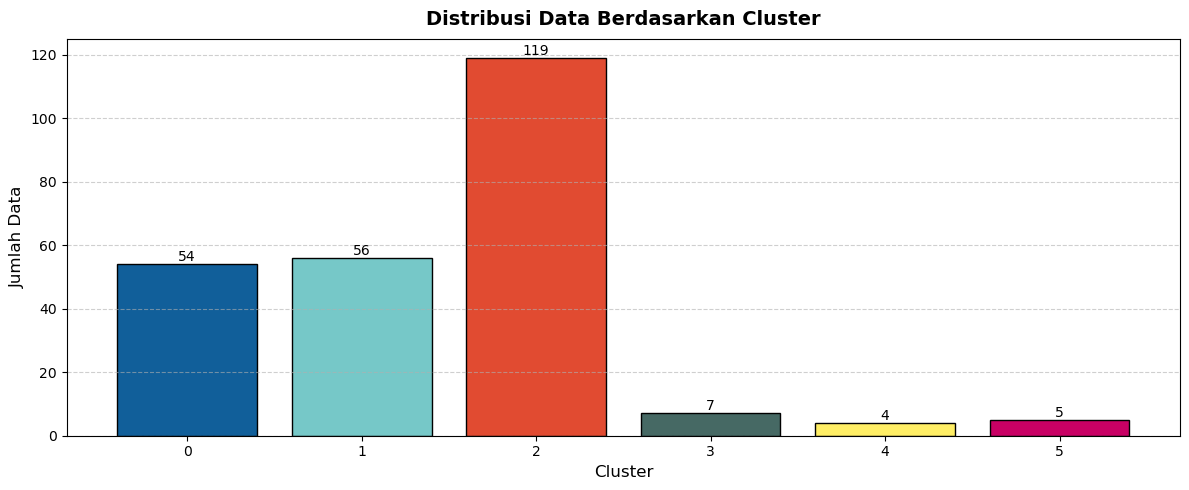

In [24]:
# Tentukan palet warna yang hanya memiliki 6 warna (sama dengan visualisasi clustering)
colors = ['#115f9a','#76c8c8','#e14b31','#466964', '#ffee65','#c80064' ]

# Pastikan nilai Cluster adalah integer
cluster_distribution['Cluster'] = cluster_distribution['Cluster'].astype(int)

# Gunakan indeks numerik untuk memilih warna
plt.figure(figsize=(12, 5))
plt.bar(
    cluster_distribution['Cluster'], 
    cluster_distribution['Count'], 
    color=[colors[i] for i in cluster_distribution['Cluster']],  # Warna sesuai cluster
    edgecolor='black'
)
plt.title('Distribusi Data Berdasarkan Cluster', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.xticks(cluster_distribution['Cluster'], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Menambahkan label jumlah data di atas diagram
for index, value in enumerate(cluster_distribution['Count']):
    plt.text(
        cluster_distribution['Cluster'].iloc[index],  # Indeks x
        value, str(value),  # Nilai y
        ha='center', va='bottom', fontsize=10
    )

# Tampilkan plot
plt.tight_layout()
plt.show()

### Visualisasi Klaster

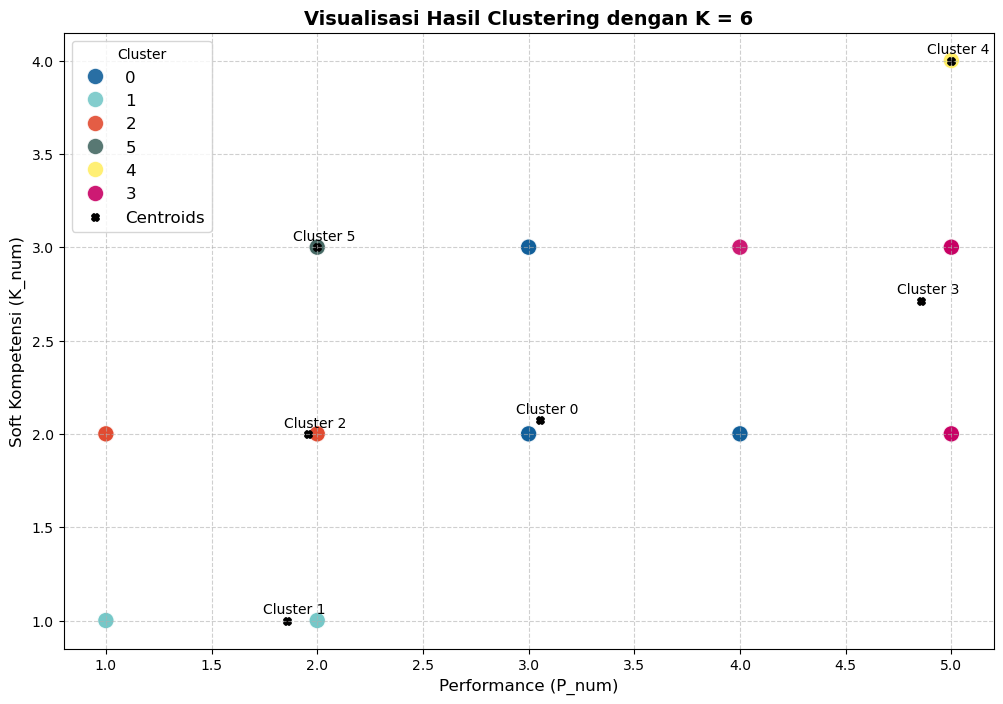

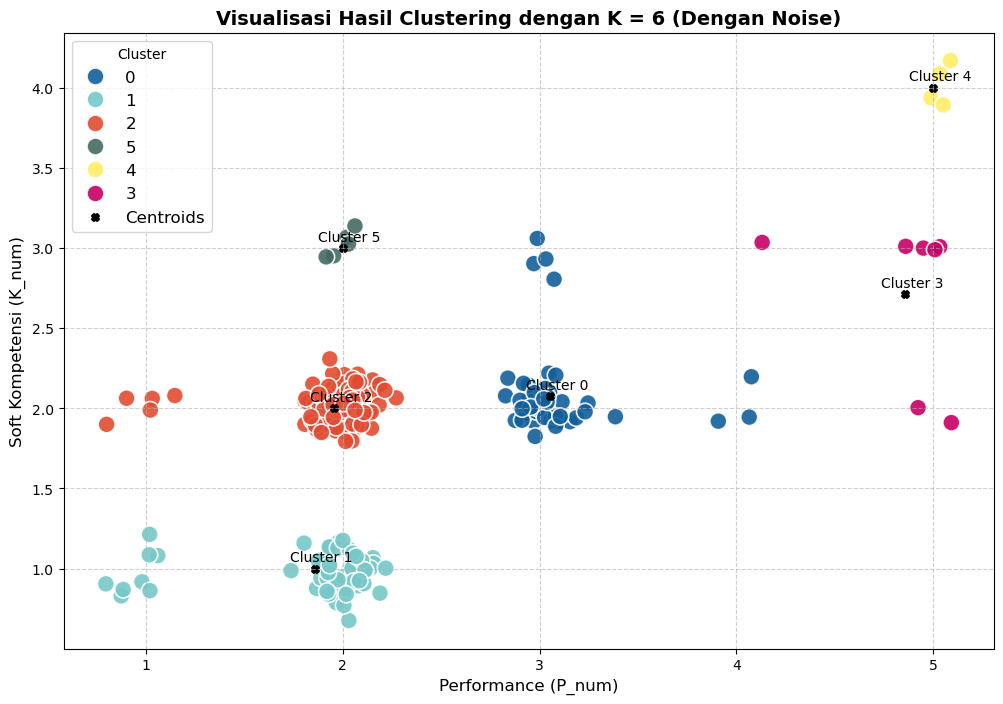

In [25]:
# Menambahkan sedikit noise ke data untuk visualisasi dengan noise
data_cleaned_noisy = data_cleaned.copy()
np.random.seed(42)
data_cleaned_noisy["P_num"] += np.random.normal(0, 0.1, size=len(data_cleaned_noisy))
data_cleaned_noisy["K_num"] += np.random.normal(0, 0.1, size=len(data_cleaned_noisy))


colors = ['#115f9a','#76c8c8','#e14b31','#466964', '#ffee65','#c80064' ]
cmap = ListedColormap(colors)


def plot_clusters(data, title):
    plt.figure(figsize=(12, 8))  # Ukuran diperbesar
    
    # Plot scatter untuk data klaster
    sns.scatterplot(
        x=data["P_num"], 
        y=data["K_num"], 
        hue=data["Cluster"], 
        palette=colors,  # Menggunakan warna yang lebih cerah
        s=150,  # Ukuran titik diperbesar
        alpha=0.9,  # Transparansi dikurangi agar lebih jelas
        edgecolor='white',  # Outline putih agar lebih terlihat
        linewidth=1.2  # Ketebalan outline
    )

    # Menandai centroid
    plt.scatter(
        data_centroids["P_num"], 
        data_centroids["K_num"], 
        color="red", 
        marker="X", 
        s=20,  # Ukuran centroid diperbesar
        edgecolor="black",  # Outline kuning agar lebih kontras
        linewidth=2,
        label="Centroids"
    )

    # Anotasi centroid
    for i, center in enumerate(centroids):
        plt.annotate(
            f"Cluster {i+0}", 
            (center[0], center[1]), 
            textcoords="offset points", 
            xytext=(5, 5), 
            ha='center', 
            fontsize=10, 
            color='black'
        )

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Performance (P_num)", fontsize=12)
    plt.ylabel("Soft Kompetensi (K_num)", fontsize=12)
    plt.legend(title="Cluster", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Visualisasi tanpa noise
plot_clusters(data_cleaned, "Visualisasi Hasil Clustering dengan K = 6")

# Visualisasi dengan noise
plot_clusters(data_cleaned_noisy, "Visualisasi Hasil Clustering dengan K = 6 (Dengan Noise)")


###  Menyesuaikan Metrik Berdasrkan Hasil Cluster K-Means untuk mengkategorikan nilai kinerja pad klalsternya

In [26]:
class AssignCategoryTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Mapping kategori sesuai dengan hasil interval cluster (memastikan semua kombinasi terdefinisi dan sesuai dengan klasternya)
        category_mapping = {
            # Sangat Istimewa (Paling Baik)
            (1, 1): "Sangat Istimewa",
            (2, 1): "Sangat Istimewa",

            # Istimewa
            (1, 2): "Istimewa",
            (2, 2): "Istimewa",
            (1, 3): "Istimewa",
            (1, 4): "Istimewa",

            # Baik Sekali
            (2, 3): "Baik Sekali",
            (2, 4): "Baik Sekali",

            # Baik
            (3, 1): "Baik",
            (3, 2): "Baik",
            (3, 3): "Baik",
            (3, 4): "Baik",
            (4, 1): "Baik",
            (4, 2): "Baik",
            (4, 3): "Baik",

            # Sedang
            (4, 4): "Sedang",
            (4, 3): "Sedang",
            (5, 2): "Sedang",
            (5, 3): "Sedang",
            
            # Kurang
            (5, 4): "Kurang"
            
        }

        # kombinasi P dan K dalam rentang 1-5 (P_num) dan 1-4 (K_num) mendapatkan kategori
        def assign_category(p_num, k_num):
            return category_mapping.get((p_num, k_num), "Kurang")  # Default ke "Kurang" jika tidak ada dalam mapping

        # Terapkan kategori ke setiap baris
        X['Nilai Kinerja'] = X.apply(lambda row: assign_category(row['P_num'], row['K_num']), axis=1)

        return X

# Definisikan pipeline clustering
pipeline_clustering = Pipeline([
    ('assign_category', AssignCategoryTransformer())
])

In [27]:
data_cleaned = pipeline_clustering.transform(data_cleaned)

###  Analisis Klaster setelah mengkategorikan klaster berdasarkan intervalnya

In [28]:
final_distribution = data_cleaned.groupby('Cluster')['Nilai Kinerja'].unique()
print("\nKategori per Cluster:")
print(final_distribution)
# print(data_cleaned)


Kategori per Cluster:
Cluster
0               [Baik]
1    [Sangat Istimewa]
2           [Istimewa]
3             [Sedang]
4             [Kurang]
5        [Baik Sekali]
Name: Nilai Kinerja, dtype: object


In [29]:
# Validate results
final_distribution = data_cleaned.groupby('Cluster')['Nilai Kinerja'].unique()
print("\nKategori per Cluster:")
print(final_distribution)


Kategori per Cluster:
Cluster
0               [Baik]
1    [Sangat Istimewa]
2           [Istimewa]
3             [Sedang]
4             [Kurang]
5        [Baik Sekali]
Name: Nilai Kinerja, dtype: object



Distribusi Cluster (Jumlah Data dan Kategori Nilai Kinerja):
  Cluster  Count Kategori_Nilai Kinerja
0       0     54                 [Baik]
1       1     56      [Sangat Istimewa]
2       2    119             [Istimewa]
3       3      7               [Sedang]
4       4      4               [Kurang]
5       5      5          [Baik Sekali]


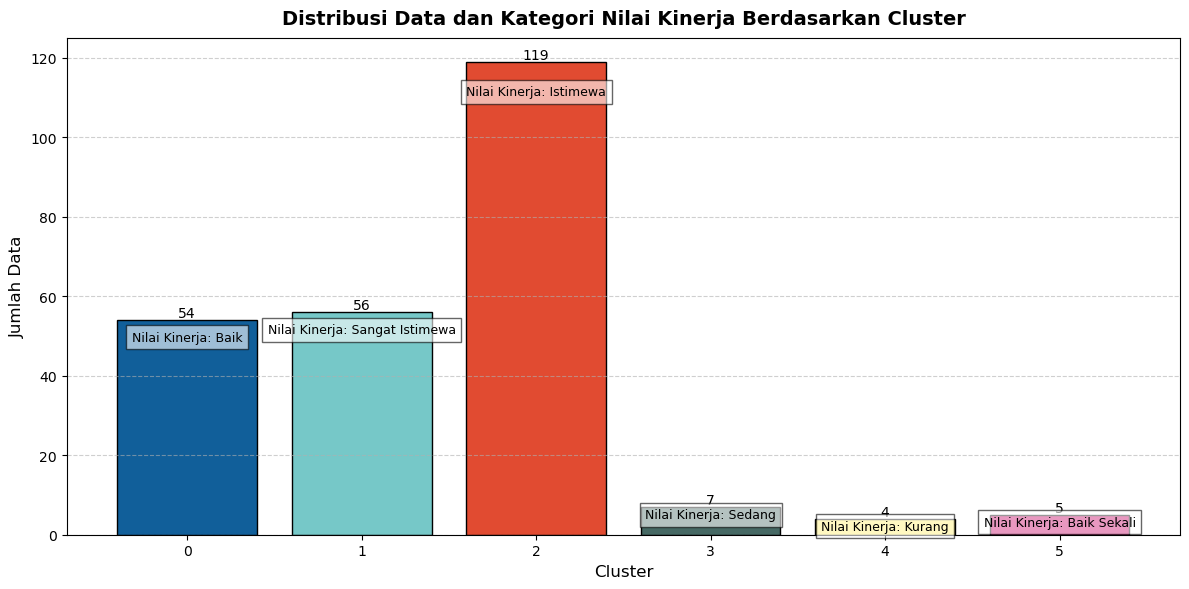

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Palet warna untuk visualisasi
colors = ['#115f9a', '#76c8c8', '#e14b31', '#466964', '#ffee65', '#c80064']
cmap = ListedColormap(colors)

# Hitung jumlah data per cluster
cluster_distribution = data_cleaned['Cluster'].value_counts().reset_index()
cluster_distribution.columns = ['Cluster', 'Count']
cluster_distribution = cluster_distribution.sort_values(by='Cluster')  # Urutkan berdasarkan Cluster

# Ambil daftar kategori Nilai_Kinerja unik per cluster
nilai_kinerja_per_cluster = data_cleaned.groupby('Cluster')['Nilai Kinerja'].unique().reset_index()
nilai_kinerja_per_cluster.columns = ['Cluster', 'Kategori_Nilai Kinerja']

# Gabungkan semua informasi ke dalam satu dataframe
cluster_distribution = cluster_distribution.merge(nilai_kinerja_per_cluster, on='Cluster')

# **Tampilkan distribusi dalam tabel**
print("\nDistribusi Cluster (Jumlah Data dan Kategori Nilai Kinerja):")
print(cluster_distribution)

# **Visualisasi Data**
plt.figure(figsize=(12, 6))

# Pastikan 'Cluster' berupa tipe data numerik
cluster_distribution['Cluster'] = cluster_distribution['Cluster'].astype(int)

# Pastikan indeks warna tidak melebihi panjang daftar warna
plt.bar(
    cluster_distribution['Cluster'], 
    cluster_distribution['Count'], 
    color=[colors[i % len(colors)] for i in cluster_distribution['Cluster']],  # Gunakan modulo untuk menghindari index error
    edgecolor='black'
)

plt.title('Distribusi Data dan Kategori Nilai Kinerja Berdasarkan Cluster', fontsize=14, fontweight='bold', pad=10)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.xticks(cluster_distribution['Cluster'], fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# **Menambahkan label jumlah data di atas batang**
for index, row in cluster_distribution.iterrows():
    plt.text(
        row['Cluster'],  # Indeks x
        row['Count'],  # Nilai y
        f"{row['Count']}",  # Hanya jumlah data
        ha='center', va='bottom', fontsize=10
    )

# **Tambahkan daftar kategori Nilai_Kinerja di bawah batang**
for index, row in cluster_distribution.iterrows():
    plt.text(
        row['Cluster'],  # Indeks x
        row['Count'] - (0.05 * row['Count']),  # Posisikan sedikit di bawah batang
        f"Nilai Kinerja: {', '.join(map(str, row['Kategori_Nilai Kinerja']))}",  # Daftar kategori nilai kinerja
        ha='center', va='top', fontsize=9, wrap=True, color='black', 
        bbox=dict(facecolor='white', alpha=0.6)
    )

plt.tight_layout()
plt.show()


#### 1. Menampilkan Data Berdasarkan Cluster dengan kategori nilia kinerjanya

In [33]:
for cluster in data_cleaned['Cluster'].unique():
    print(f"\nCluster {cluster}:")
    display(data_cleaned[data_cleaned['Cluster'] == cluster][['P_num', 'K_num', 'Cluster', 'Nilai Kinerja']])


Cluster 0:


,P_num,K_num,Cluster,Nilai Kinerja
0,3,2,0,Baik
14,3,2,0,Baik
29,3,3,0,Baik
40,3,3,0,Baik
41,3,2,0,Baik
42,3,3,0,Baik
47,3,2,0,Baik
50,3,3,0,Baik
52,3,2,0,Baik
55,3,2,0,Baik



Cluster 1:


,P_num,K_num,Cluster,Nilai Kinerja
1,2,1,1,Sangat Istimewa
10,2,1,1,Sangat Istimewa
15,2,1,1,Sangat Istimewa
16,2,1,1,Sangat Istimewa
17,2,1,1,Sangat Istimewa
21,2,1,1,Sangat Istimewa
22,2,1,1,Sangat Istimewa
28,2,1,1,Sangat Istimewa
33,2,1,1,Sangat Istimewa
37,2,1,1,Sangat Istimewa



Cluster 2:


,P_num,K_num,Cluster,Nilai Kinerja
2,2,2,2,Istimewa
3,2,2,2,Istimewa
4,2,2,2,Istimewa
5,2,2,2,Istimewa
6,2,2,2,Istimewa
...,...,...,...,...
232,2,2,2,Istimewa
233,2,2,2,Istimewa
234,2,2,2,Istimewa
235,2,2,2,Istimewa



Cluster 5:


,P_num,K_num,Cluster,Nilai Kinerja
36,2,3,5,Baik Sekali
46,2,3,5,Baik Sekali
56,2,3,5,Baik Sekali
96,2,3,5,Baik Sekali
180,2,3,5,Baik Sekali



Cluster 4:


,P_num,K_num,Cluster,Nilai Kinerja
48,5,4,4,Kurang
241,5,4,4,Kurang
242,5,4,4,Kurang
243,5,4,4,Kurang



Cluster 3:


,P_num,K_num,Cluster,Nilai Kinerja
85,5,3,3,Sedang
86,5,2,3,Sedang
87,5,3,3,Sedang
123,5,3,3,Sedang
141,4,3,3,Sedang
216,5,2,3,Sedang
219,5,3,3,Sedang


In [34]:
for cluster in data_cleaned['Cluster'].unique():
    cluster_data = data_cleaned[data_cleaned['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.describe())


Cluster 0:
         Nilai P    Nilai K      P_num      K_num
count  54.000000  54.000000  54.000000  54.000000
mean   87.500000   2.074074   3.055556   2.074074
std     2.080911   0.264351   0.231212   0.264351
min    79.000000   2.000000   3.000000   2.000000
25%    88.000000   2.000000   3.000000   2.000000
50%    88.000000   2.000000   3.000000   2.000000
75%    88.000000   2.000000   3.000000   2.000000
max    88.000000   3.000000   4.000000   3.000000

Cluster 1:
          Nilai P  Nilai K      P_num  K_num
count   56.000000     56.0  56.000000   56.0
mean    95.000000      1.0   1.857143    1.0
std      2.471658      0.0   0.353094    0.0
min     94.000000      1.0   1.000000    1.0
25%     94.000000      1.0   2.000000    1.0
50%     94.000000      1.0   2.000000    1.0
75%     94.000000      1.0   2.000000    1.0
max    101.000000      1.0   2.000000    1.0

Cluster 2:
          Nilai P  Nilai K       P_num  K_num
count  119.000000    119.0  119.000000  119.0
mean    94.294118

##### **Simpan hasil clustering ke file Excel**

In [ ]:
output_file = 'Data_Kpi_Hasil_Clustered_Kmeans.xlsx'

# Simpan seluruh data ke file Excel
data_cleaned.to_excel(output_file, index=False)

print(f"File hasil clustering telah disimpan sebagai {output_file}.")

##### **Simpan pipelines and model K_means**

In [ ]:
# Latih ulang model dengan K=6
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(data_cleaned[['P_num', 'K_num']])

# Simpan model 
joblib.dump(kmeans, 'kmeans_model.pkl')


In [ ]:
# Save pipelines and model
joblib.dump(pipeline_preprocessing, 'preprocessing_pipeline.pkl')
joblib.dump(pipeline_clustering, 'clustering_pipeline.pkl')
print("Pipeline preprocessing, K-Means model, dan pipeline kategori telah disimpan.")

In [ ]:
# Load model dan pipeline
pipeline_preprocessing = joblib.load('preprocessing_pipeline.pkl')
pipeline_clustering = joblib.load('clustering_pipeline.pkl')
kmeans_model = joblib.load('kmeans_model.pkl')

print("Pipeline preprocessing, pipeline clustering, dan model K-Means telah dimuat kembali.")

#### Proses Data Baru 

In [ ]:
# Function to process new data
def numerisasi_p_raw(nilai_p):
    """
    Fungsi untuk mengonversi nilai P ke kategori numerik berdasarkan rentang.
    """
    if nilai_p >= 101:
        return 1  # P1
    elif 91 <= nilai_p <= 100:
        return 2  # P2
    elif 81 <= nilai_p <= 90:
        return 3  # P3
    elif 71 <= nilai_p <= 80:
        return 4  # P4
    elif nilai_p <= 70:
        return 5  # P5
    else:
        return 0  # Nilai tidak valid

def numerisasi_k_raw(nilai_k):
    """
    Fungsi untuk memvalidasi nilai K (harus dalam rentang 1-5).
    """
    return nilai_k if nilai_k in [1, 2, 3, 4] else 0  # Nilai tidak valid

In [ ]:
def predict_new_data(new_data):
    """
    Fungsi untuk memproses dan mengelompokkan data baru berdasarkan model K-Means yang telah disimpan.
    Pastikan new_data memiliki kolom: 'Nilai P' dan 'Nilai K'
    """
    
    # **Step 1: Pastikan kolom sesuai**
    required_columns = ['Nilai P', 'Nilai K']
    if not all(col in new_data.columns for col in required_columns):
        raise ValueError(f"Data baru harus memiliki kolom: {required_columns}")

    # **Step 2: Konversi Nilai P dan K ke bentuk numerik (Kategori P_num dan K_num)**
    new_data['P_num'] = new_data['Nilai P'].apply(numerisasi_p_raw)
    new_data['K_num'] = new_data['Nilai K'].apply(numerisasi_k_raw)

    # **Step 3: Jalankan pipeline preprocessing**
    new_data_cleaned = pipeline_preprocessing.transform(new_data)

    # **Step 4: Pastikan hanya kolom yang diperlukan untuk clustering**
    features = new_data_cleaned[['P_num', 'K_num']].values

    # **Step 5: Prediksi klaster menggunakan model K-Means**
    new_data_cleaned['Cluster'] = kmeans_model.predict(features)

    # **Step 6: Jalankan pipeline kategori untuk mengkategorikan klaster ke dalam 'Nilai_Kinerja'**
    new_data_cleaned = pipeline_clustering.transform(new_data_cleaned)

    return new_data_cleaned



In [ ]:
# Contoh data baru
new_data = pd.DataFrame({
    'Nama Pegawai': ['X1', 'Y1', 'Z1', 'A1', 'B1', 'C1', 'C2'],  
    'Bagian/Fakultas': ['FTIK', 'FTEN', 'FTBE', 'FMIPA', 'FE', 'FT', 'Fr'],  
    'Nilai P': [4, 85, 70, 105, 103, 100,20],  
    'Nilai K': [4, 3, 4, 1, 2, 3,2]  
})

# Prediksi klaster untuk data baru
predicted_data = predict_new_data(new_data)

print(predicted_data)